<a href="https://colab.research.google.com/github/Mahekjain2706/Semi-Asynchronous-Centralized-Learning/blob/main/Sem_Asynchronous_Centralized_FL_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Round 1/10
Client 1 providing information:


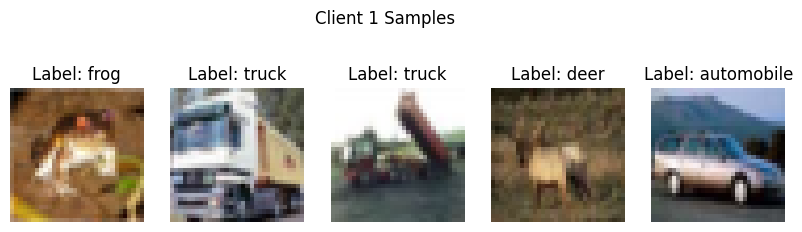

Client 2 providing information:


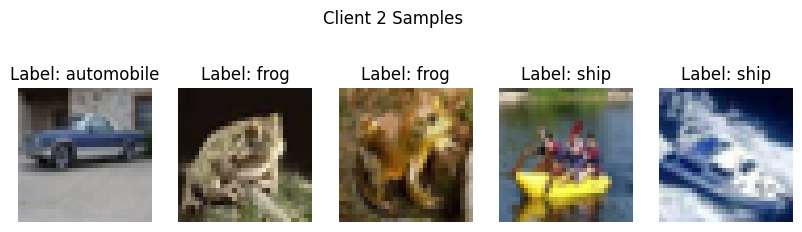

Client 4 providing information:


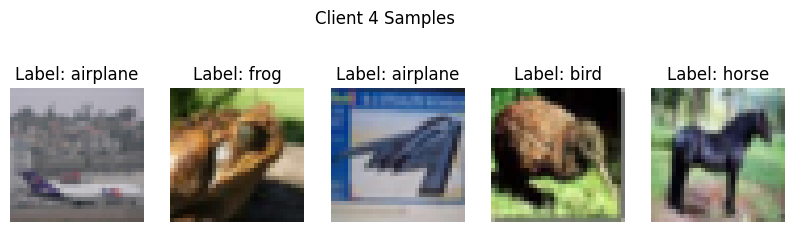

Client 5 providing information:


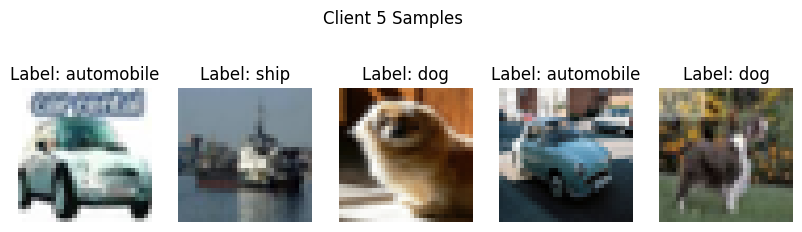

Client 3 providing information:


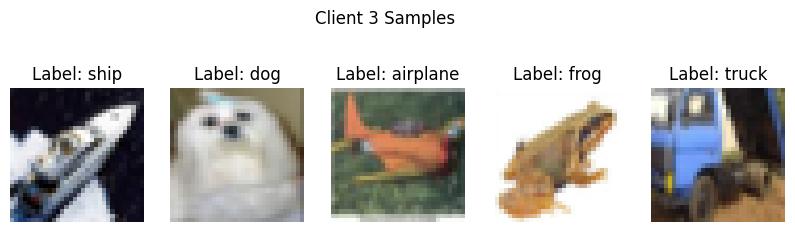

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.9322201592564583, Accuracy: 0.3238
313/313 [==============================] - 1s 4ms/step
Client 2 - Loss: 1.934672932341695, Accuracy: 0.3258
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.926231863296032, Accuracy: 0.3248
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.9422251128315926, Accuracy: 0.3154
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.9289238824844361, Accuracy: 0.3409
Round 2/10
Client 2 providing information:


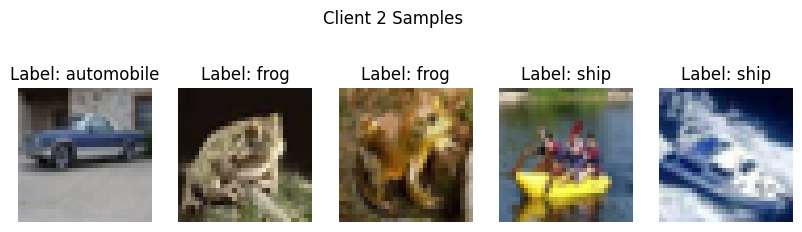

Client 3 providing information:


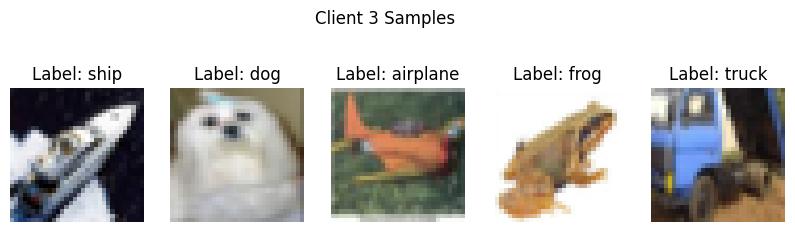

Client 5 providing information:


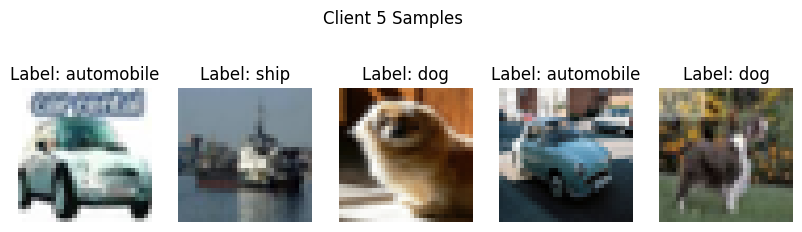

Client 4 providing information:


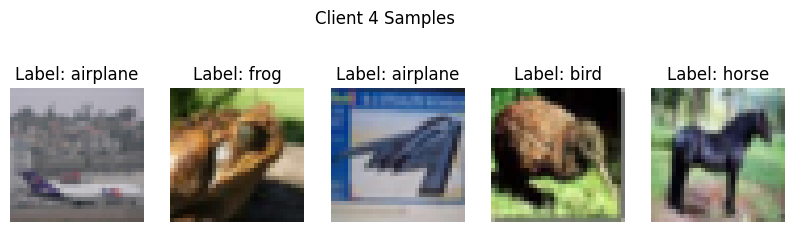

Client 1 providing information:


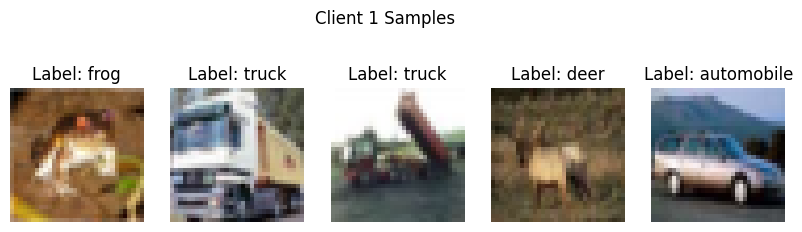

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.8429975454509258, Accuracy: 0.3643
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.8570764557182788, Accuracy: 0.3504
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.858619491416216, Accuracy: 0.3433
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.8669350202083588, Accuracy: 0.3382
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.8537742009431124, Accuracy: 0.3557
Round 3/10
Client 4 providing information:


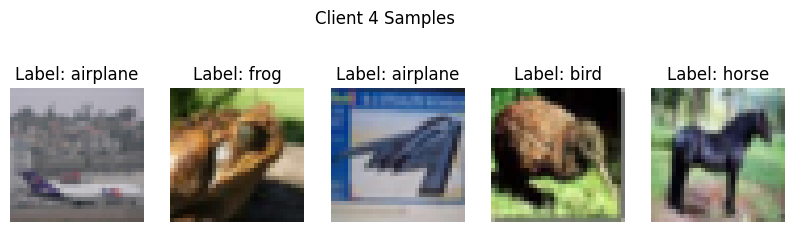

Client 3 providing information:


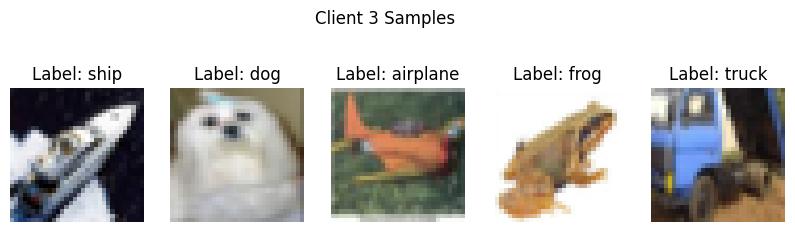

Client 5 providing information:


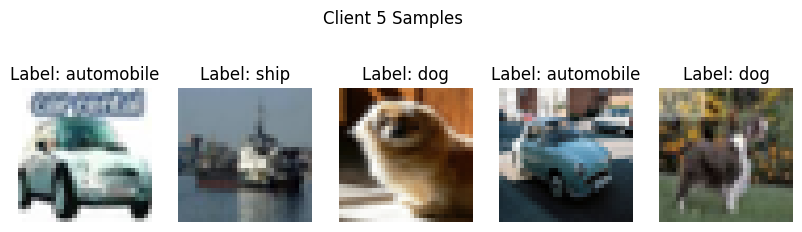

Client 2 providing information:


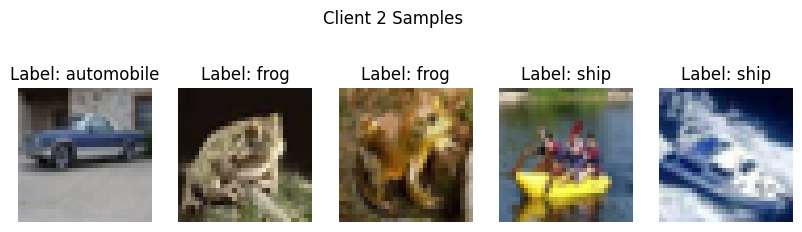

Client 1 providing information:


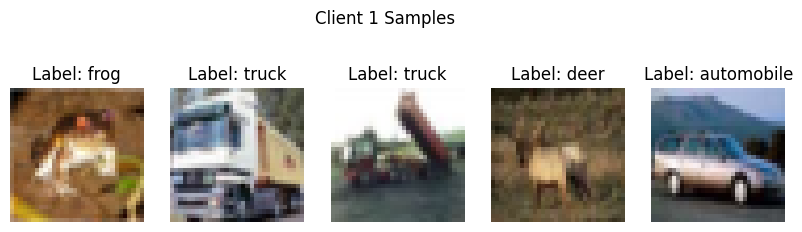

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.8161136561825872, Accuracy: 0.366
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.8131532114595175, Accuracy: 0.3715
313/313 [==============================] - 2s 5ms/step
Client 3 - Loss: 1.817589101728797, Accuracy: 0.3659
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.8218624604046345, Accuracy: 0.3622
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.8233959357574583, Accuracy: 0.3618
Round 4/10
Client 4 providing information:


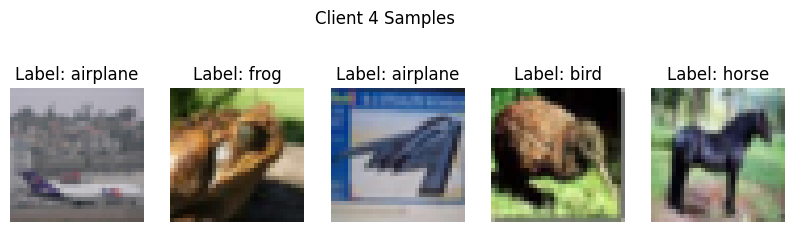

Client 2 providing information:


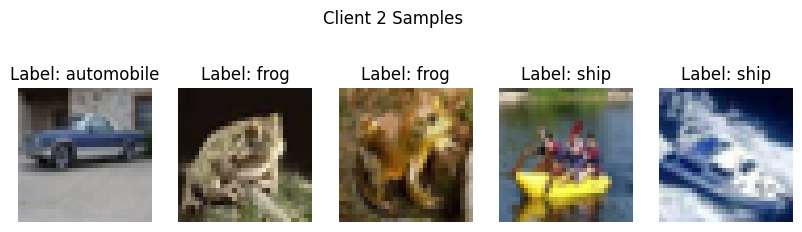

Client 1 providing information:


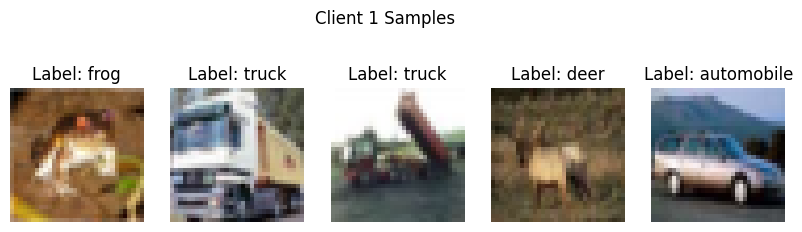

Client 3 providing information:


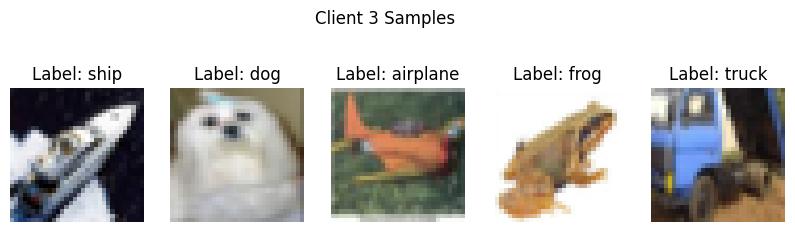

Client 5 providing information:


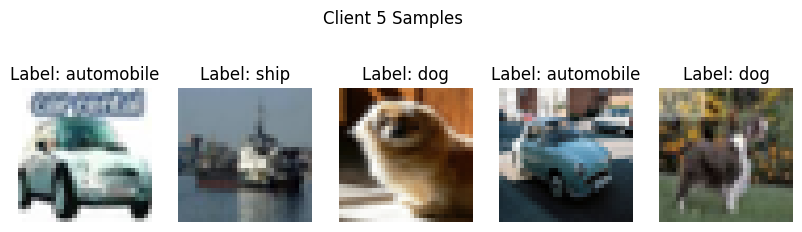

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.796970033672452, Accuracy: 0.3734
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.791923358310759, Accuracy: 0.3698
313/313 [==============================] - 1s 4ms/step
Client 3 - Loss: 1.7907004921391607, Accuracy: 0.3735
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.8096320788830518, Accuracy: 0.3621
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7946992593079805, Accuracy: 0.3709
Round 5/10
Client 3 providing information:


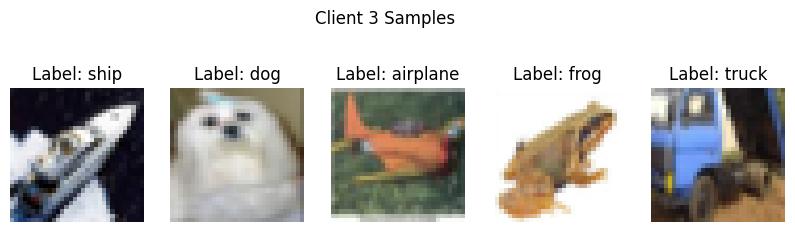

Client 2 providing information:


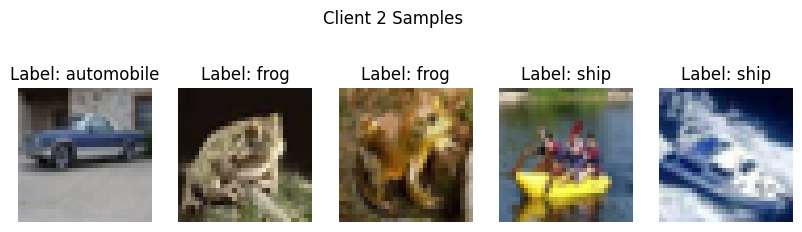

Client 5 providing information:


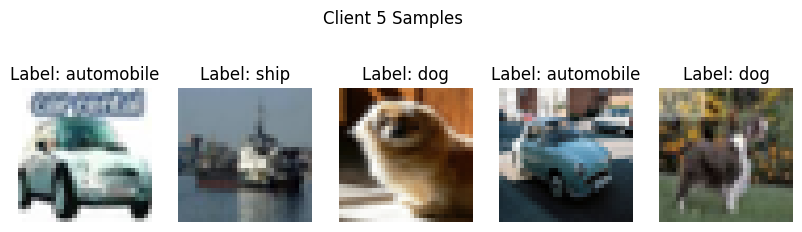

Client 4 providing information:


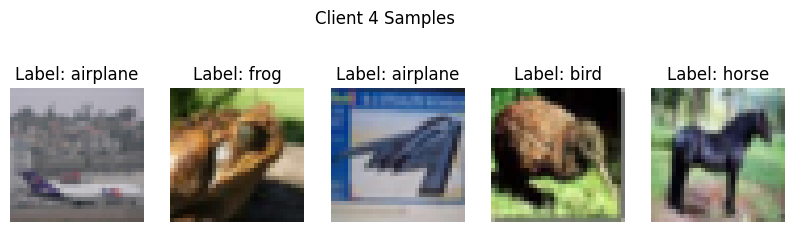

Client 1 providing information:


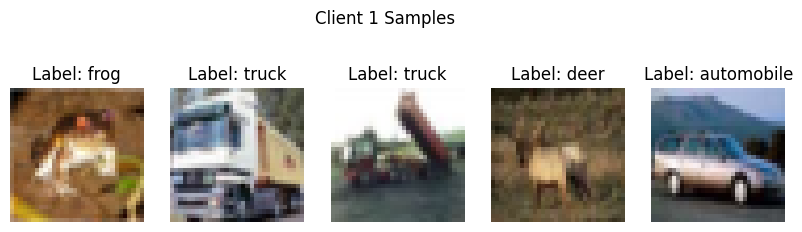

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.7674617381766438, Accuracy: 0.385
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7799844452932476, Accuracy: 0.3763
313/313 [==============================] - 1s 4ms/step
Client 3 - Loss: 1.7735700187310577, Accuracy: 0.3751
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.79065447781384, Accuracy: 0.3659
313/313 [==============================] - 1s 4ms/step
Client 5 - Loss: 1.7736558463379741, Accuracy: 0.377
Round 6/10
Client 4 providing information:


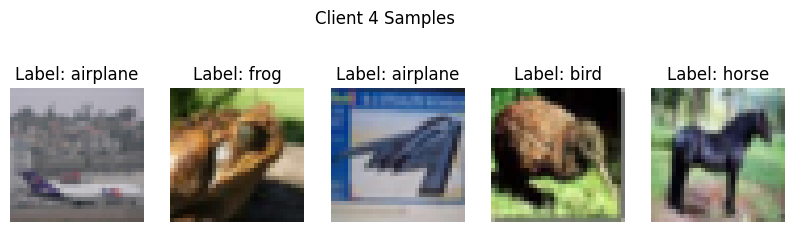

Client 1 providing information:


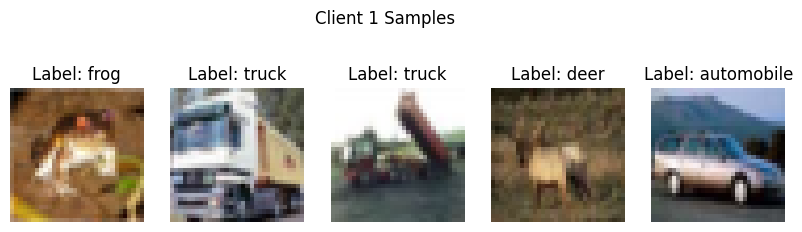

Client 3 providing information:


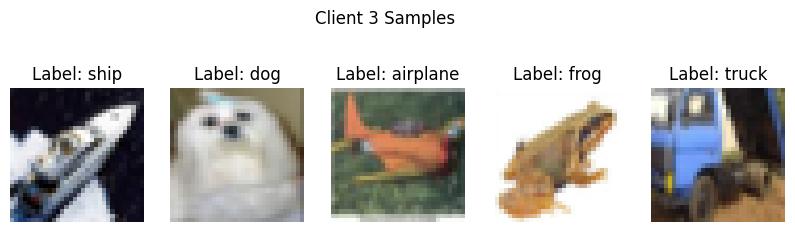

Client 5 providing information:


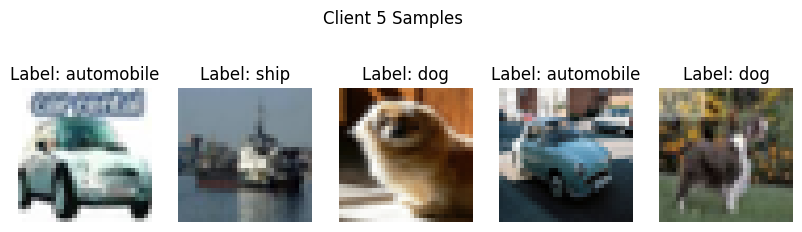

Client 2 providing information:


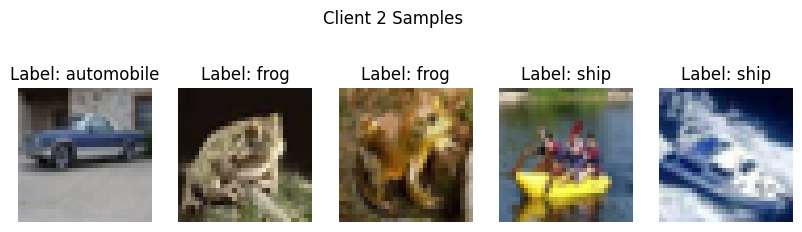

313/313 [==============================] - 2s 5ms/step
Client 1 - Loss: 1.7601397102542222, Accuracy: 0.3792
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7531271367281676, Accuracy: 0.3867
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7553181809149683, Accuracy: 0.3911
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7675224145047366, Accuracy: 0.378
313/313 [==============================] - 1s 4ms/step
Client 5 - Loss: 1.7672168780833484, Accuracy: 0.3769
Round 7/10
Client 4 providing information:


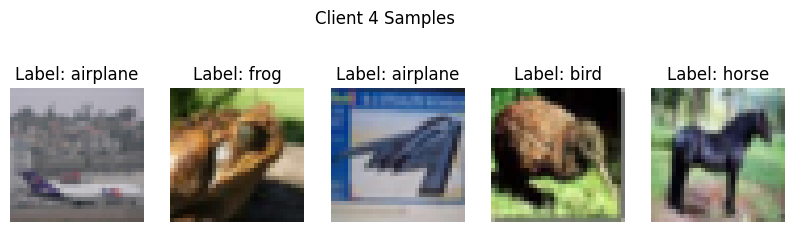

Client 5 providing information:


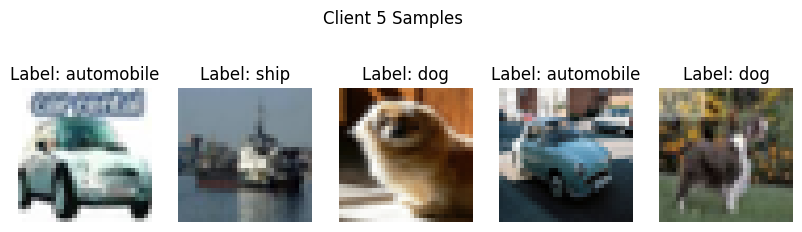

Client 2 providing information:


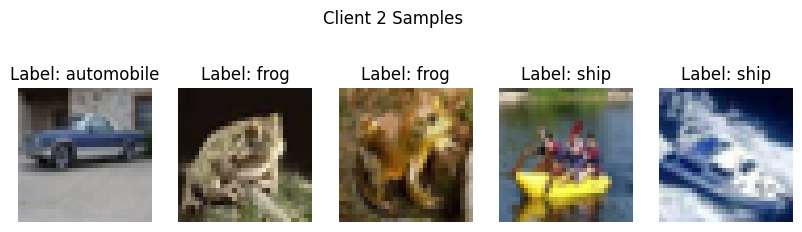

Client 1 providing information:


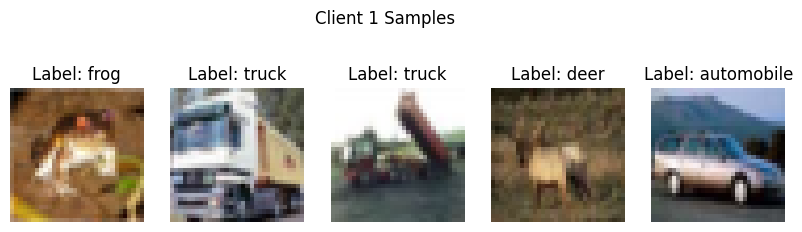

Client 3 providing information:


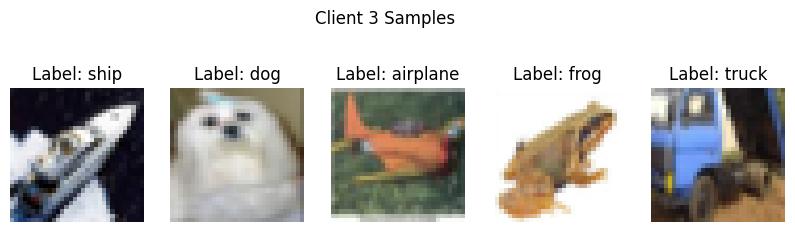

313/313 [==============================] - 1s 4ms/step
Client 1 - Loss: 1.7534611993044615, Accuracy: 0.3794
313/313 [==============================] - 1s 5ms/step
Client 2 - Loss: 1.7347019212968648, Accuracy: 0.3908
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7465696436434983, Accuracy: 0.3838
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.760001440858841, Accuracy: 0.3821
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7442526495493949, Accuracy: 0.3889
Round 8/10
Client 1 providing information:


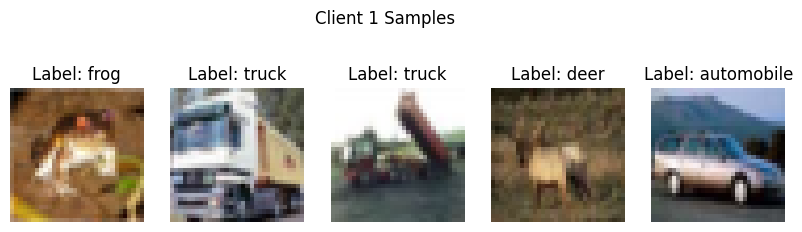

Client 3 providing information:


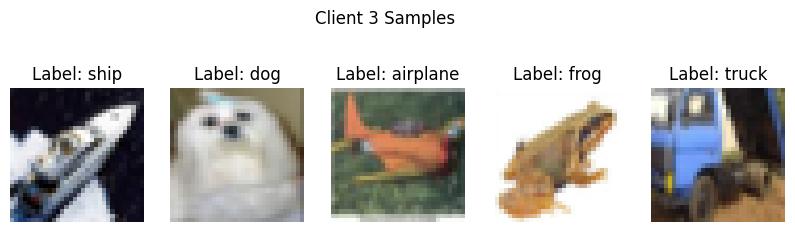

Client 4 providing information:


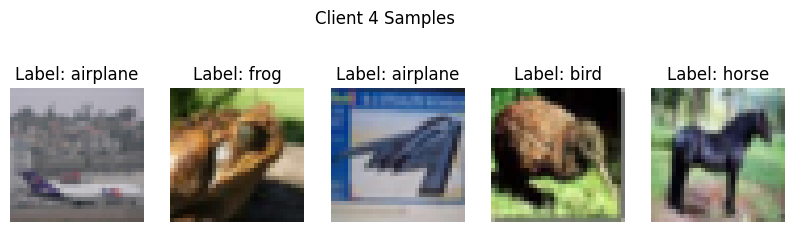

Client 5 providing information:


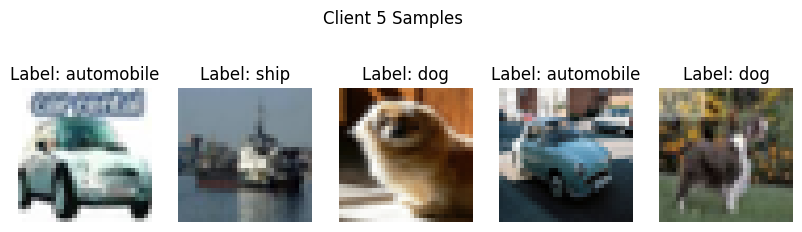

Client 2 providing information:


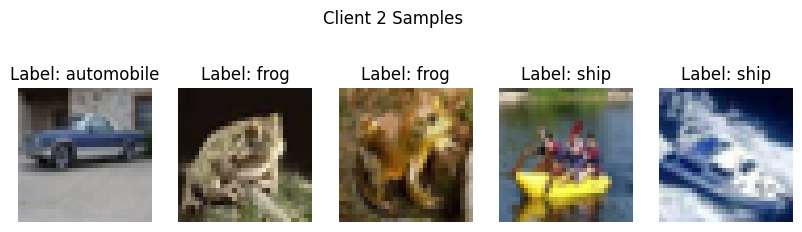

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.734803265262395, Accuracy: 0.3914
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7262578060150147, Accuracy: 0.3925
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.736057661355287, Accuracy: 0.3873
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7395755831062794, Accuracy: 0.3909
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.73943931600824, Accuracy: 0.3838
Round 9/10
Client 1 providing information:


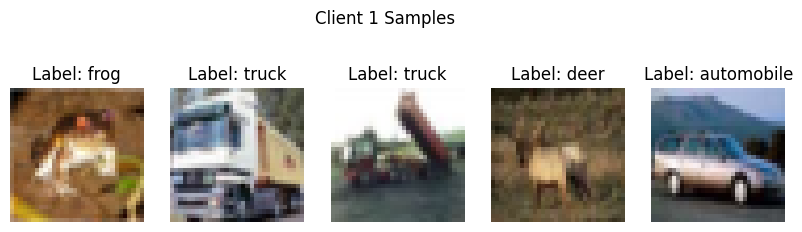

Client 4 providing information:


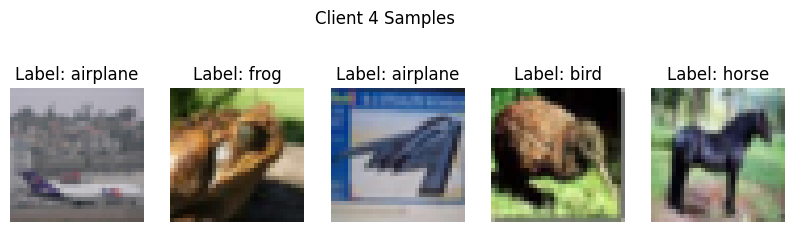

Client 2 providing information:


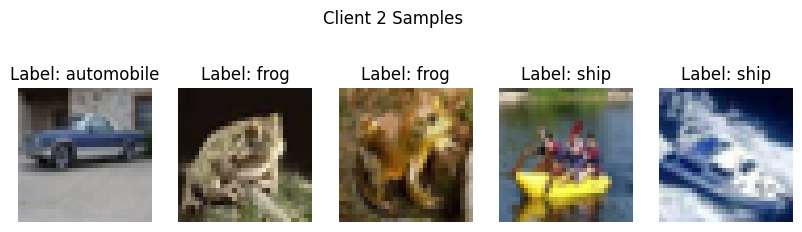

Client 3 providing information:


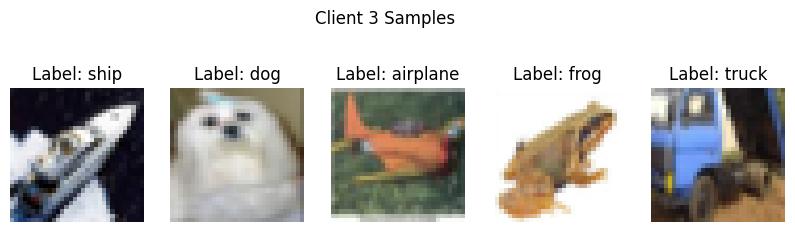

Client 5 providing information:


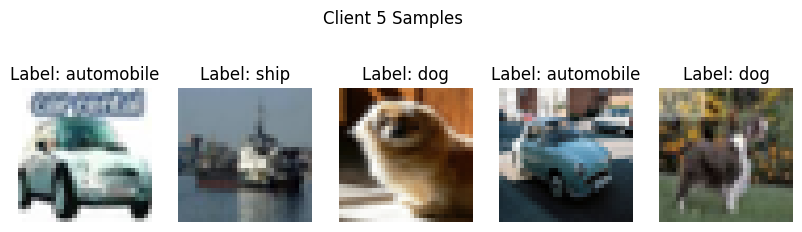

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.737684444141388, Accuracy: 0.3923
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7149441673647612, Accuracy: 0.3949
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.723013726428151, Accuracy: 0.3974
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.7192483035065234, Accuracy: 0.3973
313/313 [==============================] - 1s 4ms/step
Client 5 - Loss: 1.7327658736735583, Accuracy: 0.3978
Round 10/10
Client 2 providing information:


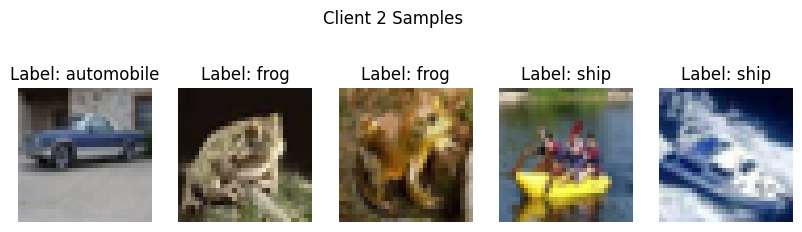

Client 1 providing information:


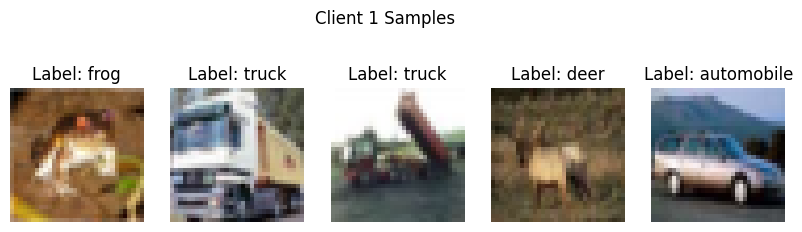

Client 3 providing information:


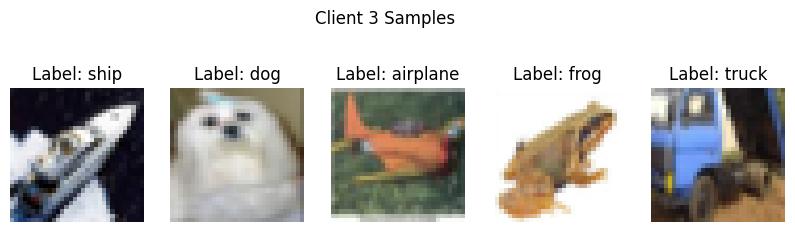

Client 4 providing information:


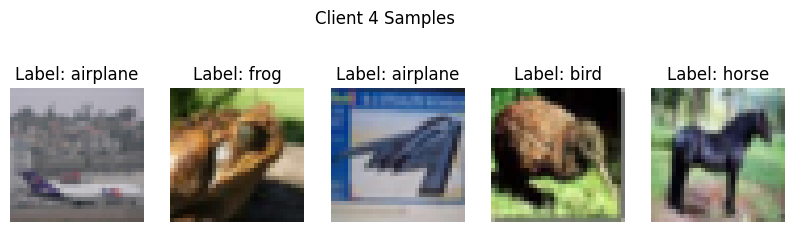

Client 5 providing information:


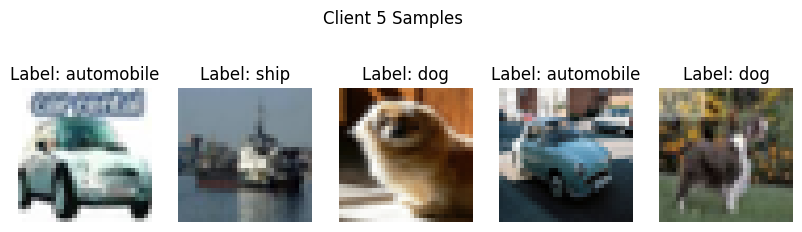

313/313 [==============================] - 1s 4ms/step
Client 1 - Loss: 1.7159683206111194, Accuracy: 0.4002
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.6964424738317727, Accuracy: 0.4059
313/313 [==============================] - 1s 4ms/step
Client 3 - Loss: 1.7109014769852162, Accuracy: 0.4009
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.7066149821724743, Accuracy: 0.4046
313/313 [==============================] - 1s 4ms/step
Client 5 - Loss: 1.704959733102098, Accuracy: 0.4062


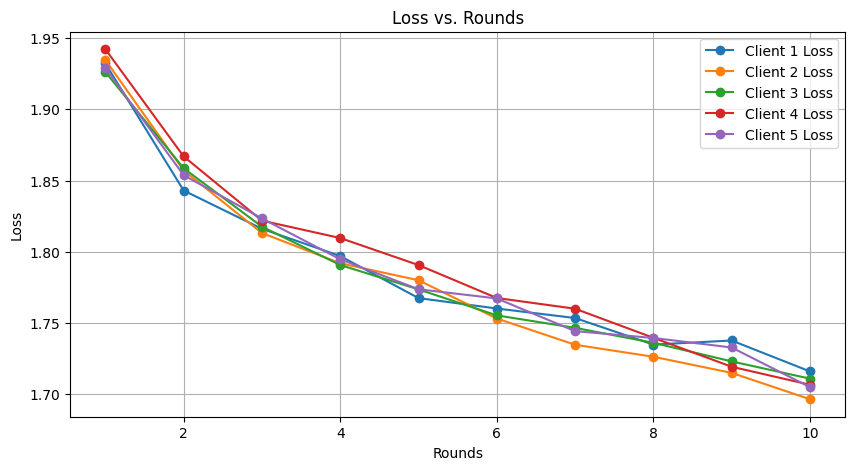

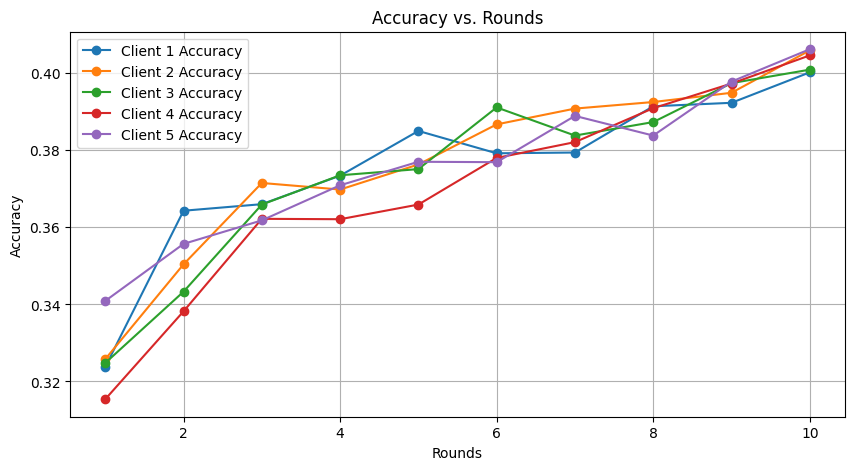

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Split training data into clients
client_data = np.array_split(X_train, 5)
client_labels = np.array_split(y_train_encoded, 5)

# Define activation functions and loss function
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    return -np.mean(np.sum(labels * np.log(predictions + 1e-9), axis=1))

# Define SimpleNN class
class SimpleNN:
    def __init__(self, input_shape, num_classes):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=input_shape),
            tf.keras.layers.Dense(128, activation='sigmoid'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    def forward(self, X):
        return self.model.predict(X)

    def backward(self, X, y, epochs, batch_size):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

# Initialize client and server models
client_models = [SimpleNN(X_train.shape[1:], 10) for _ in range(5)]
server_model = SimpleNN(X_train.shape[1:], 10)

# Hyperparameters
epochs = 5
rounds = 10
batch_size = 32

# Class names for CIFAR-10
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Function to display client samples
def display_client_samples(samples, labels, client_index):
    plt.figure(figsize=(10, 3))
    for i in range(len(samples)):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(samples[i])
        plt.title(f'Label: {class_names[np.argmax(labels[i])]}')
        plt.axis('off')
    plt.suptitle(f'Client {client_index + 1} Samples')
    plt.show()

# Semi-asynchronous federated learning
def semi_async_update(client_models, server_model, client_data, client_labels, epochs, batch_size):
    client_losses = [[] for _ in range(len(client_models))]
    client_accuracies = [[] for _ in range(len(client_models))]

    for round in range(rounds):
        print(f"Round {round+1}/{rounds}")

        client_indices = np.random.permutation(len(client_models))

        for i in client_indices:
            print(f"Client {i + 1} providing information:")
            display_client_samples(client_data[i][:5], client_labels[i][:5], i)  # Display client samples
            client_models[i].backward(client_data[i], client_labels[i], epochs, batch_size)

        # Update server model
        server_weights = [layer.get_weights() for layer in server_model.model.layers]
        client_weights = [[layer.get_weights() for layer in model.model.layers] for model in client_models]

        new_weights = []
        for layer_idx in range(len(server_weights)):
            layer_weights = [client_weights[client_idx][layer_idx] for client_idx in range(len(client_weights))]
            mean_weights = [np.mean([w[weight_idx] for w in layer_weights], axis=0) for weight_idx in range(len(layer_weights[0]))]
            new_weights.append(mean_weights)

        for layer_idx, weights in enumerate(new_weights):
            server_model.model.layers[layer_idx].set_weights(weights)

        # Evaluate client models
        for i, model in enumerate(client_models):
            client_predictions = model.forward(X_test)
            loss = cross_entropy_loss(client_predictions, y_test_encoded)
            acc = np.mean(np.argmax(client_predictions, axis=1) == np.argmax(y_test_encoded, axis=1))
            client_losses[i].append(loss)
            client_accuracies[i].append(acc)
            print(f"Client {i + 1} - Loss: {loss}, Accuracy: {acc}")

    return client_losses, client_accuracies

# Simulate semi-asynchronous federated learning
client_losses, client_accuracies = semi_async_update(client_models, server_model, client_data, client_labels, epochs, batch_size)

# Plot the results
plt.figure(figsize=(10, 5))

# Plot loss vs. rounds for each client
for i in range(len(client_losses)):
    plt.plot(range(1, rounds+1), client_losses[i], marker='o', label=f'Client {i + 1} Loss')

plt.title('Loss vs. Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))

# Plot accuracy vs. rounds for each client
for i in range(len(client_accuracies)):
    plt.plot(range(1, rounds+1), client_accuracies[i], marker='o', label=f'Client {i + 1} Accuracy')

plt.title('Accuracy vs. Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
